Stage 1: Loading and aligning data...
   'returns_df' loaded successfully.
   'presence_matrix' loaded successfully.
   ...data loaded and aligned successfully.
Stage 2: Patching SPX data holes...
     ... running SPX patch file creator 
     ... patch file './data/spx_patch.parquet' already exists. Skipping creation.
     ... successfully applied patch from './data/spx_patch.parquet'.
   ...done.
Stage 3: Identifying rebalancing dates...
   Found 540 rebalancing dates from 1980-01-31 to 2024-12-31.
Stage 4: Differentiating column types...
   Identified 131 stock columns and 7 factor columns.
Stage 5: Generating data overview dashboard ...
   Dashboard saved to ./dashboard_summary.png


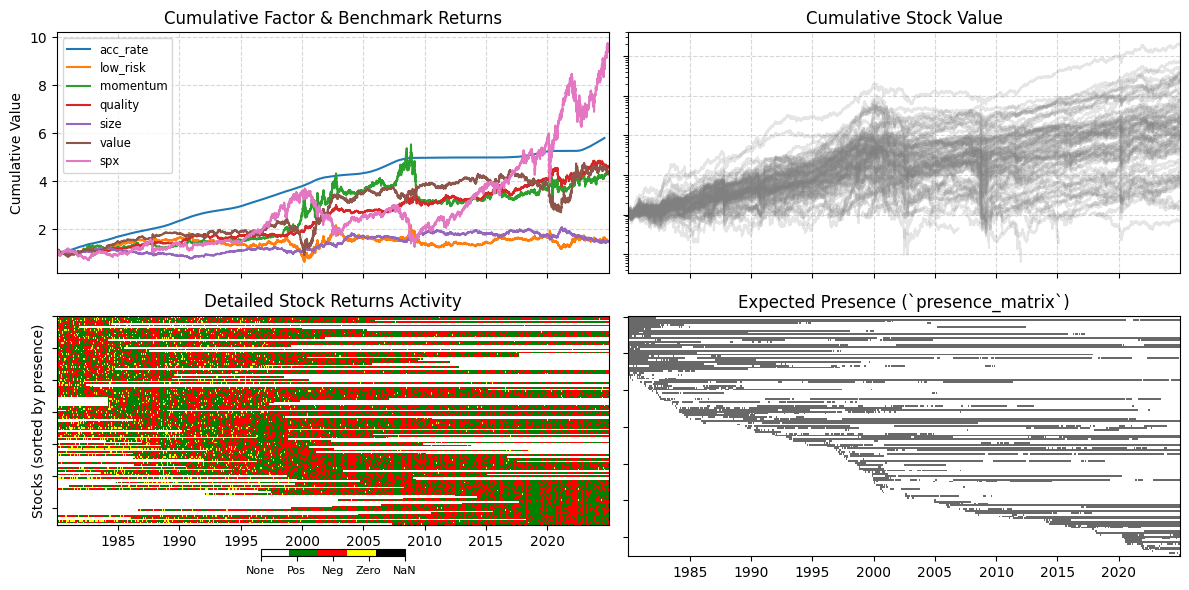

   ...dashboard generated.
Stage 6: Pre-calculating prices and volatility proxies...
   ...done.
Stage 7: Running the daily backtest loop...


100%|██████████| 11344/11344 [00:30<00:00, 371.20it/s]


   ...backtest complete.
Stage 7.1: Visualizing portfolio leverage (saving to ./leverage_and_volatility.png)...
   Leverage plot saved to ./leverage_and_volatility.png


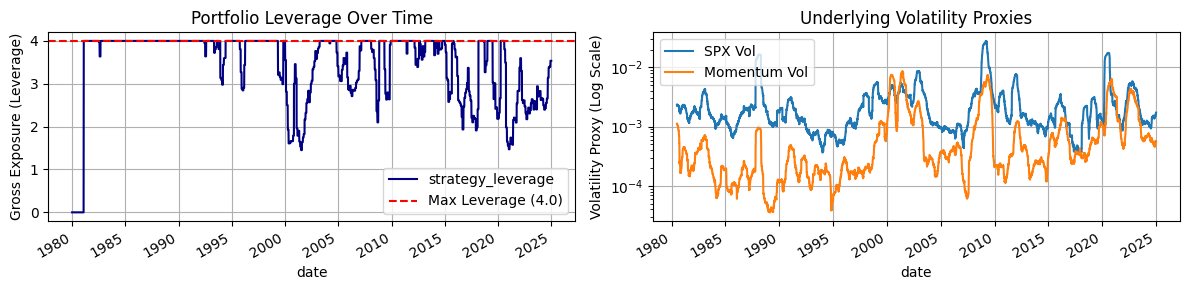

   ...done.
Stage 8: Calculating final performance metrics...
   ...metrics calculated.
Stage 9: Generating final performance report...


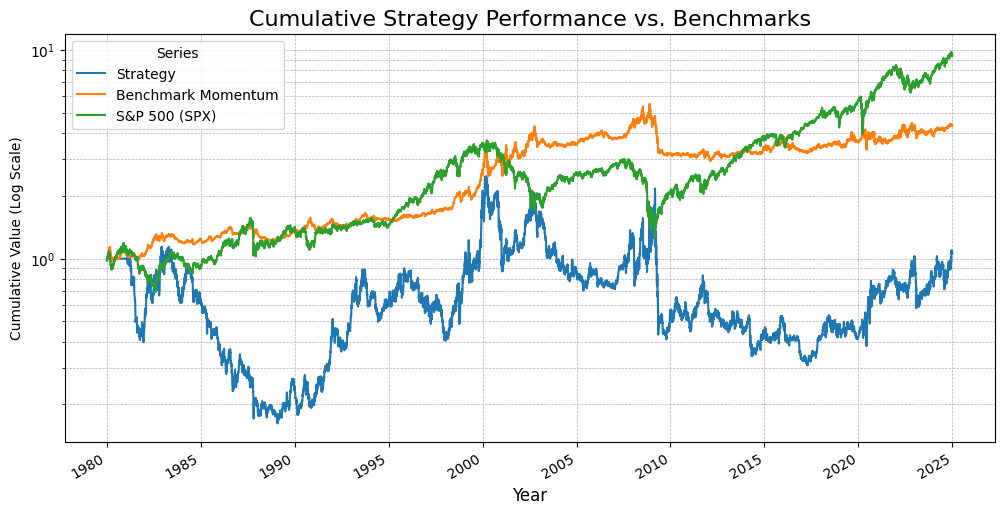


      Strategy Performance Summary
   Annualized Return                 0.12%
   Annualized Volatility            36.65%
   Annualized Sharpe Ratio           -0.10
   Annualized Alpha (vs 6 factors)   -1.08%
   Information Ratio                 -0.04
   ...report generated. Task complete.


In [5]:
import pandas as pd
from helpers.plotting_utils import plot_dashboard, plot_leverage_and_volatility
from helpers.data_utils import create_spx_patch_file, data_loader, apply_spx_hole_patch, generate_custom_presence_matrix
from helpers.strategy_logic import get_base_weights, get_risk_scale
from helpers.reporting_utils import calculate_performance_metrics, plot_performance_summary
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


# --- Configuration ---
# --- Input Files ---
returns_file_path = './data/returns_df.parquet'
presence_file_path = './data/presence_matrix.parquet'
patch_filename = './data/spx_patch.parquet'
# if false we use our custom (see helpers.data_utils.generate_custom_presence_matrix(...) presence matrix )
EXTERNAL_PRESENCE = True

# --- Output Files ---
dashboard_output_path = './dashboard_summary.png'
leverage_output_path = './leverage_and_volatility.png'
performance_output_path = './strategy_performance.png'
save_json_path = './strategy_report.json'

# --- Strategy Parameters ---
percentile_leg = 0.2
non_stock_columns = [
    'acc_rate', 'low_risk', 'momentum',
    'quality', 'size', 'value', 'spx'
]
figsize = (12, 6)

# --- Stage 1: Load Data ---
print("Stage 1: Loading and aligning data...")
data = data_loader(
    returns_file_path=returns_file_path,
    presence_file_path=presence_file_path,
    non_stock_columns=non_stock_columns
)
if not data:
    raise SystemExit("Data loading failed. Halting execution.")
presence_matrix = data['presence_matrix']
returns_df = data['returns_df']


assert returns_df.index.equals(
    presence_matrix.index), "Indices of returns_df and presence_matrix do not match!"
print("   ...data loaded and aligned successfully.")

# --- Stage 2: Patch SPX Data ---
print("Stage 2: Patching SPX data holes...")
create_spx_patch_file(
    returns_df, patch_filename=patch_filename, force_creation=False)
apply_spx_hole_patch(patch_filename, returns_df)
print("   ...done.")

# --- Stage 3: Identify Rebalancing Dates ---
print("Stage 3: Identifying rebalancing dates...")
rebal_dates = set(returns_df.index.to_series().resample('ME').last())
print(f"   Found {len(rebal_dates)} rebalancing dates from {min(rebal_dates).date()} to {max(rebal_dates).date()}.")

# --- Stage 4: Identify Column Types ---
print("Stage 4: Differentiating column types...")
stock_columns = list(set(returns_df.columns) - set(non_stock_columns))
print(
    f"   Identified {len(stock_columns)} stock columns and {len(non_stock_columns)} factor columns.")

if not EXTERNAL_PRESENCE:
    presence_matrix = generate_custom_presence_matrix(returns_df=returns_df,
                                                      stock_columns=stock_columns)

# --- Stage 5: Initial Data Visualization ---
print(
    f"Stage 5: Generating data overview dashboard ...")
plot_dashboard(
    returns_df=returns_df,
    presence_matrix=presence_matrix,
    non_stock_columns=non_stock_columns,
    stock_columns=stock_columns,
    figsize=figsize,
    save_png_path=dashboard_output_path
)
print("   ...dashboard generated.")

# --- Stage 6: Pre-calculate Data for Backtest ---
print("Stage 6: Pre-calculating prices and volatility proxies...")
prices_df = (1 + returns_df[stock_columns].fillna(0)).cumprod()
returns_for_vol = returns_df[['spx', 'momentum']]
squared_returns = returns_for_vol**2
rolling_sum_sq = squared_returns.rolling(window=126).sum()
vol_proxy_df = (rolling_sum_sq * 21 / 126).shift(1)
print("   ...done.")

# --- Stage 7: Run Main Backtest Loop ---
print("Stage 7: Running the daily backtest loop...")
current_weights = pd.Series(0.0, index=stock_columns)
strategy_returns = pd.Series(
    0.0, index=returns_df.index, dtype=float, name="strategy_returns")
strategy_leverage = pd.Series(
    0.0, index=returns_df.index, dtype=float, name="strategy_leverage")
current_leverage = 0.0

# MAIN STRATEGY LOOP
for i in tqdm(range(1, len(returns_df.index))):
    date = returns_df.index[i-1]
    if date in rebal_dates:
        base_weights = get_base_weights(
            date, presence_matrix, prices_df, stock_columns, percentile_leg=percentile_leg)
        w_scale = get_risk_scale(date, vol_proxy_df)
        current_weights = base_weights * w_scale
        current_leverage = base_weights.abs().sum() * w_scale
    daily_return = (current_weights * returns_df.iloc[i].fillna(0)).sum()
    strategy_returns.iloc[i] = daily_return
    strategy_leverage.iloc[i] = current_leverage
print("   ...backtest complete.")

# --- Stage 7.1: Visualize Leverage ---
print(
    f"Stage 7.1: Visualizing portfolio leverage (saving to {leverage_output_path})...")
plot_leverage_and_volatility(
    strategy_leverage=strategy_leverage,
    vol_proxy_df=vol_proxy_df,
    figsize=(figsize[0], figsize[1] / 2),
    save_png_path=leverage_output_path
)
print("   ...done.")

# --- Stage 8: Calculate Performance Metrics ---
print("Stage 8: Calculating final performance metrics...")
metrics = calculate_performance_metrics(
    strategy_returns=strategy_returns,
    returns_df=returns_df
)
print("   ...metrics calculated.")

# --- Stage 9: Generate Final Report ---
print(
    f"Stage 9: Generating final performance report...")
plot_performance_summary(
    strategy_returns=strategy_returns,
    returns_df=returns_df,
    metrics=metrics,
    save_png_path=performance_output_path,
    save_json_path=save_json_path,
    figsize=figsize
)
print("   ...report generated. Task complete.")